Crochet vs. Knitting Image Classification

In this notebook we:
1. scrape images of crochet and knitting stiches for train, val and test data
2. scrub data of images not suitable for training and convert images to useable formats
3. augment and transform images to enhance model training datasets
4. initalize torch CNN classifier with convolutional, pooling, relu, normalization and fully connected layers
5. train the model for 15 epochs using NLL criterion and Adam optimizer
6. track loss and accuracy of train and validation data
7. evaluate using test data

In [68]:
#import packages
import requests
import os
import random
from bs4 import BeautifulSoup
from selenium import webdriver
import shutil 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from tqdm.notebook import tqdm
from PIL import Image 
import splitfolders
%pip install numpy==1.26.4
import numpy 

#set directories
dir = 'stitches'
splits = "train_test_data"


In [69]:
#helper function for downloading images for training data

def download_images(dir, url_source, num_pages, label):

    no_access = 0

    #loop through number of website pages for images
    for i in range(1, num_pages+1):

        #get the url for single or multiple pages of a website
        if num_pages ==1:
            url = url_source
        elif i == 1:
            url = url_source[:url_source.rindex("page")]
        else:
            url = url_source.format(i)

        #use BeautifulSoup to parse the html for images
        page = requests.get(url)

        #integrate selenium for JavaScript generated content
        if not page:
            chrome_options = webdriver.ChromeOptions()
            chrome_options.add_argument('--headless=new')
            driver = webdriver.Chrome(options=chrome_options)
            driver.get(url) 
            driver.implicitly_wait(10)
            soup = BeautifulSoup(driver.page_source, 'html.parser')
        else:
            soup = BeautifulSoup(page.content, 'html.parser')

        images = soup.findAll('img')

        #loop through and save images to appropriate folder
        for image in images:
            if image.get('src') is not None:

                #sometimes the src did not have full url, check for http
                if str(image.get('src'))[:4] !=  "http":
                    full_url = "http:" + str(image.get('src'))
                else:
                    full_url = str(image.get('src'))

                #request full_url of image for download
                try:
                    r = requests.get(full_url, stream=True)
                    if r.status_code == 200: #status OK
                        file_name = image['src'][image['src'].rindex("/") + 1:]
                        with open(f"{dir}/{label}_stitches/{file_name}.jpg", 'wb') as f:
                            r.raw.decode_content = True
                            shutil.copyfileobj(r.raw, f)
                except:
                    no_access += 1

    print(no_access, "images could not be accessed")
    
    return "images are downloaded"
#source: https://towardsdatascience.com/a-tutorial-on-scraping-images-from-the-web-using-beautifulsoup-206a7633e948

In [84]:
#download images for stitches

#create directories if they do not exist alreaedy
if not os.path.exists(f'{dir}/crochet_stitches'):
    os.makedirs(f'{dir}/crochet_stitches')
if not os.path.exists(f'{dir}/knitting_stitches'):
    os.makedirs(f'{dir}/knitting_stitches')

#download images from various sources
#crochet stitches
download_images(dir, "https://newstitchaday.com/category/stitchionary/crochet-stitches/page/{}/", 29, "crochet")
download_images(dir, "https://richtexturescrochet.com/category/crochet-stitches/page/{}/", 19, "crochet")
download_images(dir, "https://blog.bellacococrochet.com/category/stitch-library/page/{}/", 9, "crochet")
download_images(dir, "https://www.gathered.how/knitting-and-crochet/crochet/crochet-stitches", 1, "crochet")
download_images(dir, "https://makeanddocrew.com/crochet-borders/", 1, "crochet")
download_images(dir, "https://www.gathered.how/knitting-and-crochet/crochet/free-granny-square-patterns", 1, "crochet")
download_images(dir, "https://dabblesandbabbles.com/basic-crochet-stitches/", 1, "crochet")

#knitting stitches
download_images(dir, "https://newstitchaday.com/category/stitchionary/knitting-stitches/page/{}/", 38, "knitting")
download_images(dir, "https://learnknittingonline.com/category/knitting-stitch-patterns/page/{}/", 3, "knitting")
download_images(dir, "https://www.gathered.how/knitting-and-crochet/knitting/knitting-stitch-patterns", 1, "knitting")
download_images(dir, "https://www.knittingstitchpatterns.com/search/label/knit-purl-stitches", 1, "knitting")
download_images(dir, "https://nimble-needles.com/knitting-techniques-library/", 1, "knitting")
download_images(dir, "https://learnknittingonline.com/category/knitting-stitch-patterns/", 1, "knitting")
download_images(dir, "https://pattern-duchess.com/25-simple-knit-stitch-patterns-for-beginners/", 1, "knitting")



0 images could not be accessed
321 images could not be accessed
0 images could not be accessed
26 images could not be accessed
<Response [403]>
51 images could not be accessed
26 images could not be accessed
0 images could not be accessed
0 images could not be accessed
<Response [403]>
<Response [403]>
<Response [403]>
88 images could not be accessed
26 images could not be accessed
0 images could not be accessed
<Response [403]>
106 images could not be accessed
<Response [403]>
30 images could not be accessed
0 images could not be accessed


'images are downloaded'

In [90]:
#clean up the images a bit - various ads, icons and logos to be removed and naming conventions addressed
for filename in os.listdir(f'{dir}/crochet_stitches'):
    f = os.path.join(f'{dir}/crochet_stitches', filename)
    substring_list = ['logo', 'Logo', '.gif', 'account', 'popup', 'placeholder', 'search', 'no-image', 'footer', '.svg', 
                       'PageView', 'Instagram', 'Facebook', "Pinterest", "Youtube",
                         "apple", 'PremierYarns', 'tiktok', "Matt", "Sarah"]
    if any(substring in filename for substring in substring_list):
        os.remove(f) 
    elif (".jpg.jpg" in filename) | (".jpeg.jpg" in filename) | (".png.jpg" in filename):
        os.rename(f, f[:-4])

for filename in os.listdir(f'{dir}/knitting_stitches'):
    f = os.path.join(f'{dir}/knitting_stitches', filename)
    substring_list = ['logo', 'Logo', '.gif', 'account', 'popup', 'placeholder', 'search', 'no-image', 'footer', '.svg',
                       "PageView", 'Instagram', 'Facebook', "Pinterest", "Youtube", 'youtube', 'PremierYarns', "Matt", "knittingstitches.png", 
                         "Ad", "Sarah", 'apple', 'chick-bunny', 'tiktok']
    if any(substring in filename for substring in substring_list):
        os.remove(f) 
    elif (".jpg.jpg" in filename) | (".jpeg.jpg" in filename) | (".png.jpg" in filename):
        os.rename(f, f[:-4])

#need to convert png images and also need to deal with these newstitchaday images with text describing label
for image in os.listdir(f'{dir}/crochet_stitches'):
  p = os.path.join(f'{dir}/crochet_stitches', image)
  if image!='.DS_Store':
    im = Image.open(p)
    #crop if it's a new stitch a day photo
    substring_list = ['nsad', "NSAD"]
    if any(substring in image for substring in substring_list):     
      width, height = im.size
      if width== 300:
          left, top, right, bottom = 150, 0, 300, 169
          im = im.crop((left, top, right, bottom))
          im.save(f"{dir}/crochet_stitches/{image}")
    # If is png image, convert
    if im.format == 'PNG':
      # and is not RGBA
      if im.mode != 'RGBA':
        im.convert("RGBA").save(f"{dir}/crochet_stitches/{image}")

for image in os.listdir(f'{dir}/knitting_stitches'):
  p = os.path.join(f'{dir}/knitting_stitches', image)
  if image!='.DS_Store':
    im = Image.open(p)
    #crop if it's a new stitch a day photo
    substring_list = ['nsad', "NSAD"]
    if any(substring in image for substring in substring_list):     
      width, height = im.size
      if width== 300:
          left, top, right, bottom = 150, 0, 300, 169
          im = im.crop((left, top, right, bottom))
          im.save(f"{dir}/knitting_stitches/{image}")
    # If is png image, convert
    if im.format == 'PNG':
      # and is not RGBA
      if im.mode != 'RGBA':
        im.convert("RGBA").save(f"{dir}/knitting_stitches/{image}")

In [102]:
#split the data into train, validation and test
splitfolders.ratio(f'{dir}/', output=f"{splits}/", seed=1337, ratio=(.6, 0.3, 0.1)) 

#how many images of each 
print('total crochet and knitting stitches \n')
print(len([name for name in os.listdir(f'{dir}/crochet_stitches')]), 'crochet')
print(len([name for name in os.listdir(f'{dir}/knitting_stitches')]), 'knitting \n')
print('total training stitches \n')
print(len([name for name in os.listdir(f'./{splits}/train/crochet_stitches')]), 'crochet')
print(len([name for name in os.listdir(f'./{splits}/train/knitting_stitches')]), 'knitting \n')
print('total validation stitches\n')
print(len([name for name in os.listdir(f'./{splits}/val/crochet_stitches')]), 'crochet')
print(len([name for name in os.listdir(f'./{splits}/val/knitting_stitches')]), 'knitting \n')
print('total test stitches\n')
print(len([name for name in os.listdir(f'./{splits}/test/crochet_stitches')]), 'crochet')
print(len([name for name in os.listdir(f'./{splits}/test/knitting_stitches')]), 'knitting \n')


Copying files: 1455 files [00:01, 956.78 files/s]

total crochet and knitting stitches 

720 crochet
736 knitting 

total training stitches 

431 crochet
441 knitting 

total validaation stitches

215 crochet
220 knitting 

total test stitches

73 crochet
75 knitting 



Text(0.5, 1.0, 'Knitting')

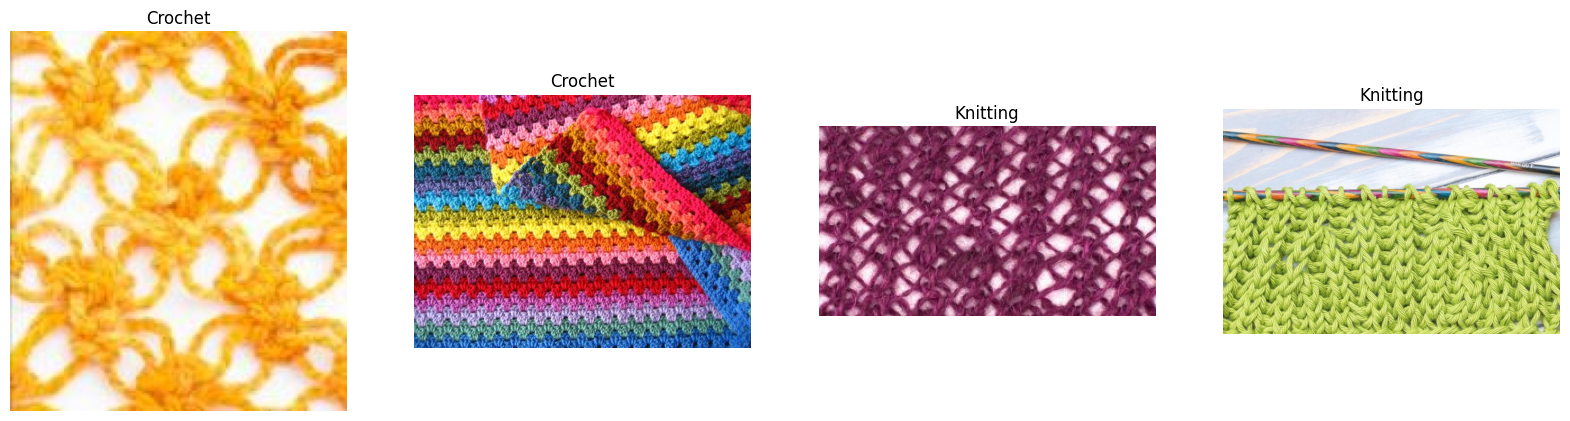

In [103]:
#take a look at some random images
img1 = mpimg.imread(f'{dir}/crochet_stitches/{random.choice(os.listdir(f"{dir}/crochet_stitches"))}')
img2 = mpimg.imread(f'{dir}/crochet_stitches/{random.choice(os.listdir(f"{dir}/crochet_stitches"))}')
img3 = mpimg.imread(f'{dir}/knitting_stitches/{random.choice(os.listdir(f"{dir}/knitting_stitches"))}')
img4 = mpimg.imread(f'{dir}/knitting_stitches/{random.choice(os.listdir(f"{dir}/knitting_stitches"))}')

#plot 
fig = plt.figure(figsize=(20, 20)) 

#subplot with 1 row, 4 cols
fig.add_subplot(1, 4, 1) 
plt.axis('off') 
plt.imshow(img1) 
plt.title("Crochet") 

fig.add_subplot(1, 4, 2) 
plt.axis('off') 
plt.imshow(img2) 
plt.title("Crochet") 

fig.add_subplot(1, 4, 3) 
plt.axis('off') 
plt.imshow(img3) 
plt.title("Knitting") 

fig.add_subplot(1, 4, 4) 
plt.axis('off') 
plt.imshow(img4) 
plt.title("Knitting") 



In [104]:
#Data Augmentation and Initalizing Datasets

#use the standard mean and std values for channels of Imagenet (though these are not Imagenet photos)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

#inverse transformation for plotting.
unnormalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

#add data augmentation to regularize the network 
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(0.3),
    transforms.RandomVerticalFlip(0.2),
    transforms.ColorJitter(hue=.1, saturation=.1, contrast=.1),
    # transforms.RandomRotation(20, interpolation=transforms.InterpolationMode.BILINEAR),
    # transforms.GaussianBlur(7, sigma=(0.1, 1.0)),
    transforms.ToTensor(), 
    normalize])

#don't want all these augementations on validation data, just resizing and normalization
validation_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    normalize])

#transform our train, val and test datasets 
train_dataset =  torchvision.datasets.ImageFolder(f'./{splits}/train', transform=train_transforms)
validation_dataset = torchvision.datasets.ImageFolder(f'./{splits}/val', transform=validation_transforms)
test_dataset = torchvision.datasets.ImageFolder(f'./{splits}/test', transform=validation_transforms)


In [105]:
#CNN classifier 
class CNN(torch.nn.Module):

  def __init__(self):
    super().__init__()

    #initialize the different layers including convolutional, pooling, fully connected layers and normalization
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding = 1)
    self.norm1 = nn.BatchNorm2d(16)
    self.pool1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(16, 64, kernel_size=3, padding = 1)
    self.norm2 = nn.BatchNorm2d(64)
    self.pool2 = nn.MaxPool2d(2)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding = 1)
    self.norm3 = nn.BatchNorm2d(128)
    self.pool3 = nn.MaxPool2d(2)
    self.flatten = nn.Flatten(1, 3)
    self.fc1 = nn.Linear(131072, 2)

  def forward(self, x):
          
    #conv/relu layers before pooling
    x = self.conv1(x)
    x = self.norm1(x)
    x = F.relu(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.norm2(x)
    x = F.relu(x)    
    x = self.pool2(x)
    x = self.conv3(x)
    x = self.norm3(x)
    x = F.relu(x)
    x = self.pool3(x)
    x = self.flatten(x)

    #fully connected layer
    x = self.fc1(x)

    #nll loss needs softmax
    return F.log_softmax(x, dim=1)
  

In [106]:
#training

def get_loss_and_correct(model, batch, criterion):
  # returns a tuple:
  # - loss for the batch (Tensor)
  # - number of correctly classified examples in the batch (Tensor)
  data, target = batch
  #move batch to device
  if torch.cuda.is_available():
    data, target = data.cuda(), target.cuda()
  #forward pass output and loss
  output = model(data)
  loss = criterion(output, target)
  #number of correctly classified examples
  y_pred = torch.argmax(output, dim=1)
  num_correct = (y_pred == target).sum()
  for i in range(len(y_pred)):
    if y_pred[i] == target[i]:
      c.append((data[i], y_pred[i], target[i]))
    else:
      incorrect.append((data[i], y_pred[i], target[i]))
  return (loss, num_correct)

def step(loss, optimizer):
  #backward pass and update
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

#set parameters for epochs and batch size and intialize lists
N_EPOCHS = 15
BATCH_SIZE = 64
c = []
incorrect = []

#use dataloader and shuffle our training data
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, num_workers=4)

#initalize CNN model, loss and optimizer
model = CNN()
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

#set model to train
model.train()

#move model and criterion to device
if torch.cuda.is_available():
  model = model.cuda()
  criterion = criterion.cuda()
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")

#initalize loss and accuracy stores
train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

#set up progress bar
pbar = tqdm(range(N_EPOCHS))

for i in pbar:
  #initalize loss and accuracy for each epoch
  total_train_loss = 0.0
  total_train_correct = 0.0
  total_validation_loss = 0.0
  total_validation_correct = 0.0

  #set model to train
  model.train()

  #loop through each batch of data, collect losses and step along gradient
  for batch in tqdm(train_dataloader, leave=False):
    loss, correct = get_loss_and_correct(model, batch, criterion)
    step(loss, optimizer)
    total_train_loss += loss.item()
    total_train_correct += correct.item()

  #collect losses for validation set, do not step along gradient
  with torch.no_grad():
    for batch in validation_dataloader:
      loss, correct = get_loss_and_correct(model, batch, criterion)
      total_validation_loss += loss.item()
      total_validation_correct += correct.item()

  #collect total epoch loss and accuracy for train and val datasets
  mean_train_loss = total_train_loss / len(train_dataset)
  train_accuracy = total_train_correct / len(train_dataset)
  mean_validation_loss = total_validation_loss / len(validation_dataset)
  validation_accuracy = total_validation_correct / len(validation_dataset)
  train_losses.append(mean_train_loss)
  validation_losses.append(mean_validation_loss)
  train_accuracies.append(train_accuracy)
  validation_accuracies.append(validation_accuracy)

  #progress bar output
  pbar.set_postfix({'train_loss': mean_train_loss, 'validation_loss': mean_validation_loss, 'train_accuracy': train_accuracy, 'validation_accuracy': validation_accuracy})

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

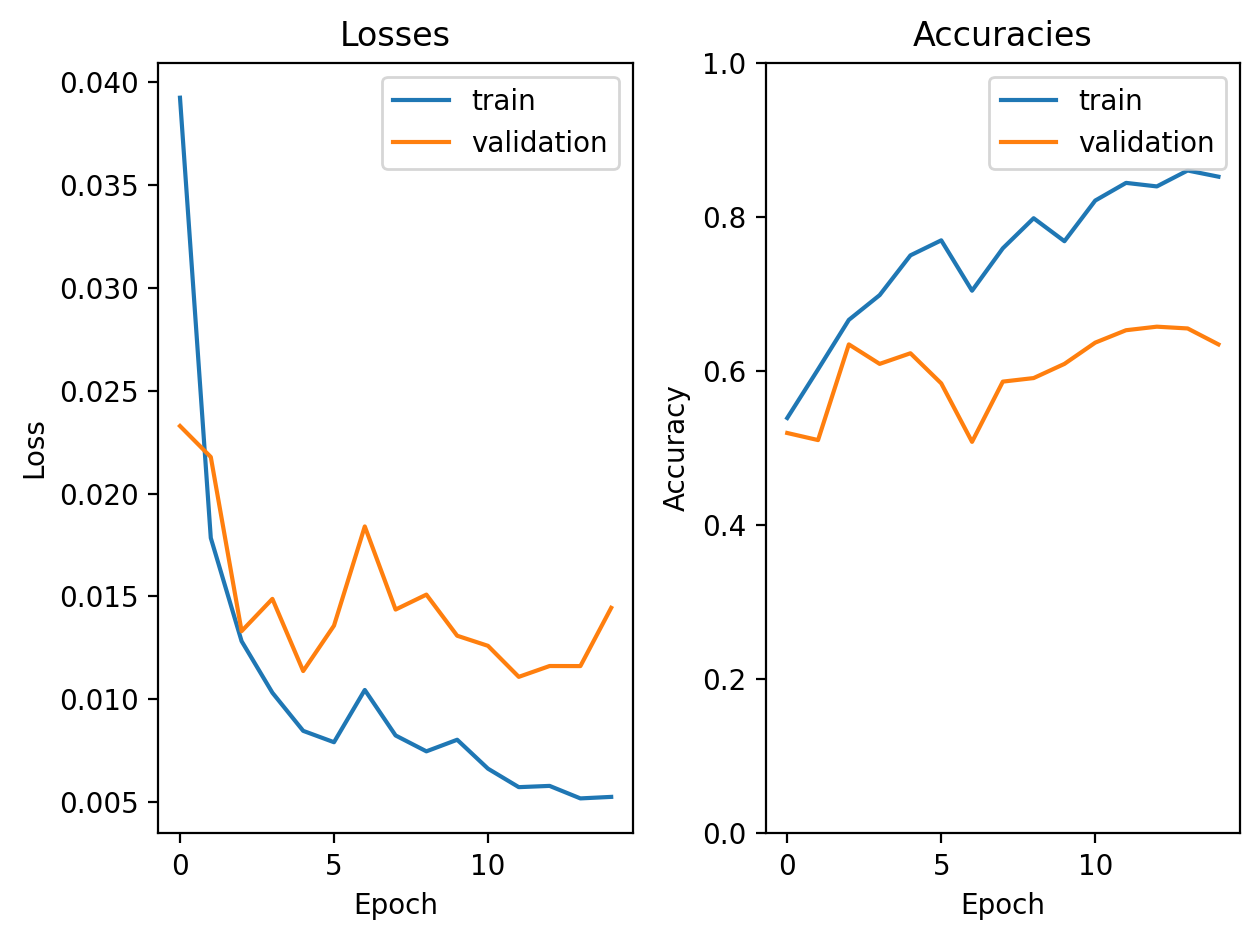

In [107]:
#plot our loss and accuracy for train and validation sets
plt.figure(dpi=200)

plt.subplot(121)
plt.plot(train_losses, label='train')
plt.plot(validation_losses, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses')
plt.legend()

plt.subplot(122)
plt.plot(train_accuracies, label='train')
plt.plot(validation_accuracies, label='validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.title('Accuracies')

plt.tight_layout()

In [108]:
#evaluate test loss and accuracy
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True, num_workers=4)

with torch.no_grad():
  for batch in test_dataloader: #should be 1
    loss, correct = get_loss_and_correct(model, batch, criterion)

#collect total loss and accuracy for test data
test_loss = loss.item() / len(test_dataset)
test_accuracy = correct.item() / len(test_dataset)
print('test loss:', test_loss)
print('test accuracy:', test_accuracy)

test loss: 0.004816350099202749
test accuracy: 0.7094594594594594


This model recieves an accuracy of 70.9% on the test set. It could likely be improved if we were able to gather more training data. Given the loss trajectories of the train and validation sets above, further training on the existing set could possibly lead to overfit. 

Accuracy might be further improved by transfer learning. 